In [1]:
import numpy as np
import pandas as pd
import datetime
import geopandas as gpd
pd.set_option("display.max_colwidth", 0)
pd.set_option("display.max_rows", 500)
pd.set_option("display.max_columns", 500)
pd.set_option("display.width", 1000)
pd.options.display.float_format = '{:.5f}'.format
import warnings
warnings.filterwarnings("ignore")
# %pip install contextily

import matplotlib.colors as mcolors
from shapely.geometry import Point
from geopandas import GeoDataFrame

In [2]:
%%time
df_shap = pd.read_csv("./output/food_localness_final_oct_new_shap_values.csv", sep=",", header=0)
df_shap = df_shap.drop(columns=['account_id','customer_lon','customer_lat','vendor_id','vendor_lon','vendor_lat'])
print(df_shap.shape[0])
df_shap.head()

2782961
CPU times: user 13.3 s, sys: 2.37 s, total: 15.6 s
Wall time: 19.4 s


,order_id,shap_customer_lon,shap_customer_lat,shap_basket_amount_lc,shap_price_per_item,shap_order_time_hour,shap_total_duration,shap_estimated_rent,shap_entropy_0.5km,shap_entropy_2km,shap_entropy_5km,shap_incentive_amount_lc,shap_incentive_delivery,shap_incentive_menu_discount,shap_incentive_voucher_wallet,shap_main_cuisine,shap_isweekend,shap_consistency,shap_total_orders,shap_rating,shap_n_rating,shap_restaurant_count_0.5km,shap_restaurant_count_0.5_1km,shap_restaurant_count_1_2km,shap_restaurant_count_2_3km,shap_restaurant_count_3_4km,shap_restaurant_count_4_5km
0,1304769890,-0.00700,-0.01416,-0.01049,-0.03658,0.05246,-0.05788,-0.01585,0.00036,-0.00766,0.00060,0.01495,-0.00232,0.01096,0.00100,-0.02045,0.00069,0.00302,-0.00381,-0.00390,0.00393,-0.07875,-0.01005,0.01626,-0.02434,0.00044,-0.00006
1,1304769334,0.00155,-0.01932,-0.00655,-0.03077,0.05136,-0.03860,-0.01359,-0.01035,-0.00673,0.00457,0.01726,-0.00001,0.00937,0.00102,-0.00446,-0.00003,-0.00126,-0.00231,0.01493,0.00445,-0.06185,-0.01068,0.00895,-0.01686,0.00066,-0.00035
2,1306219965,-0.01347,-0.02119,0.00027,0.02538,0.03483,0.01954,-0.01046,-0.00508,-0.01530,-0.00191,-0.00811,0.00005,-0.01162,-0.00086,0.00638,-0.00073,-0.00293,-0.00914,0.00652,0.02472,-0.08642,-0.00981,-0.00867,-0.00991,-0.00350,-0.00520
3,1295994041,-0.01150,-0.02168,-0.00094,0.02542,0.03613,0.05872,-0.01017,-0.00242,-0.01868,-0.00022,-0.00852,0.00004,-0.00976,-0.00056,0.01619,-0.00055,-0.00360,-0.00835,0.01021,0.02568,-0.09305,-0.01366,-0.00944,-0.00957,-0.00265,-0.00616
4,1304742536,-0.00545,-0.02307,-0.00619,-0.01789,0.02276,-0.02453,-0.00766,-0.03050,-0.01598,0.00167,0.02036,-0.00529,0.00153,0.00001,-0.01623,0.00070,-0.00121,-0.00197,-0.04450,-0.02838,-0.06445,-0.00714,-0.01947,-0.00973,-0.00985,-0.02598


In [3]:
df_localness = pd.read_csv('./data/food_localness_final_oct_new.csv')
print(df_localness.shape[0])

2782961


In [4]:
df_shap_merged = df_localness.merge(df_shap, on='order_id')
print(df_shap_merged.shape[0])

2782961


# Hexagon - best visualization for 2 million points

,index,geometry
h3_polyfill,,
8843a1264bfffff,0,"POLYGON ((55.33872 25.14613, 55.34047 25.14184, 55.34558 25.14071, 55.34893 25.14387, 55.34717 25.14816, 55.34206 25.14929, 55.33872 25.14613))"
8843a12dc5fffff,0,"POLYGON ((55.45700 24.91333, 55.45874 24.90905, 55.46383 24.90792, 55.46717 24.91107, 55.46543 24.91535, 55.46034 24.91648, 55.45700 24.91333))"
8843a1a44dfffff,0,"POLYGON ((55.03979 25.36401, 55.04157 25.35971, 55.04669 25.35860, 55.05003 25.36178, 55.04825 25.36607, 55.04313 25.36719, 55.03979 25.36401))"
8843a12957fffff,0,"POLYGON ((55.29591 24.83245, 55.29766 24.82818, 55.30274 24.82705, 55.30607 24.83020, 55.30432 24.83447, 55.29924 24.83560, 55.29591 24.83245))"
8843ae945dfffff,0,"POLYGON ((55.57552 24.90639, 55.57725 24.90210, 55.58234 24.90097, 55.58570 24.90411, 55.58396 24.90840, 55.57887 24.90953, 55.57552 24.90639))"


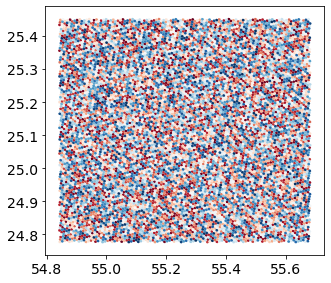

In [77]:
from shapely.geometry import box

bound_lat = [24.776468,25.451666]
bound_lon = [54.842954,55.680861] # 25.637066, 55.849584 

dubai_box = gpd.GeoDataFrame(geometry=[box(bound_lon[0],bound_lat[0],bound_lon[1],bound_lat[1])],crs="EPSG:4326")
# %pip install h3pandas
# create hexagon within the UAE border
import geopandas as gpd
import h3pandas

resolution = 8 # Average edge length: 500m
hexagons = dubai_box.h3.polyfill_resample(resolution)
ax = hexagons.plot(figsize=(5, 5), cmap='RdBu')
hexagons.head()

In [137]:
%%time

selected_feature = 'incentive_voucher_wallet'
# Some continuous features to be considered: estimated_rent, incentive_amount_lc, entropy_0.5km, restaurant_count_0.5km,
# price_per_item, order_time_hour, basket_amount_lc, total_orders, consistency, incentive_delivery
# incentive_menu_discount, incentive_voucher_wallet
df_onefeature = df_shap_merged[['account_id','order_id','customer_lon','customer_lat', selected_feature,'shap_'+selected_feature]]
geometry2 = [Point(xy) for xy in zip(df_onefeature.customer_lon, df_onefeature.customer_lat)]
gdf_onefeature = GeoDataFrame(df_onefeature, crs="EPSG:4326", geometry=geometry2)
# gdf_test = gdf_onefeature.head(1000)
# gdf_test.head()

CPU times: user 16.2 s, sys: 140 ms, total: 16.4 s
Wall time: 16.3 s


In [138]:
%%time
mean_hex = gpd.sjoin(gdf_onefeature, hexagons, op='within') 
hexagon_agg = mean_hex[['index_right',selected_feature,'shap_'+selected_feature]].groupby('index_right').agg('mean')
hexagon_agg_ordernumber = hexagons.merge(hexagon_agg,left_index=True,right_index=True) # focus on hexagons that contains delivery data
print(hexagon_agg_ordernumber.shape[0])
hexagon_agg_ordernumber.head()

1351
CPU times: user 4.99 s, sys: 1.3 s, total: 6.29 s
Wall time: 6.29 s


,index,geometry,incentive_voucher_wallet,shap_incentive_voucher_wallet
8843a1264bfffff,0,"POLYGON ((55.33872 25.14613, 55.34047 25.14184, 55.34558 25.14071, 55.34893 25.14387, 55.34717 25.14816, 55.34206 25.14929, 55.33872 25.14613))",0.02041,-0.00034
8843a12001fffff,0,"POLYGON ((55.27802 25.01141, 55.27977 25.00713, 55.28486 25.00600, 55.28820 25.00916, 55.28644 25.01344, 55.28135 25.01457, 55.27802 25.01141))",0.04067,0.00044
8843acc8d3fffff,0,"POLYGON ((55.44574 25.27096, 55.44749 25.26666, 55.45261 25.26553, 55.45597 25.26870, 55.45421 25.27300, 55.44910 25.27413, 55.44574 25.27096))",0.03326,-0.00002
8843a13113fffff,0,"POLYGON ((55.13894 25.03428, 55.14071 25.03000, 55.14580 25.02888, 55.14913 25.03204, 55.14736 25.03632, 55.14227 25.03744, 55.13894 25.03428))",0.04163,0.00088
8843a1354dfffff,0,"POLYGON ((55.21048 25.10810, 55.21224 25.10382, 55.21734 25.10270, 55.22068 25.10586, 55.21892 25.11014, 55.21382 25.11127, 55.21048 25.10810))",0.03145,0.00017


In [139]:
# hexagon_agg_ordernumber[selected_feature].describe()
# df_shap_merged[selected_feature].median()

In [140]:
feature_mean = hexagon_agg_ordernumber[selected_feature].median()
# feature_mean = hexagon_agg_ordernumber[hexagon_agg_ordernumber[selected_feature]!=0][selected_feature].median()
print('feature mean values:',feature_mean)
shap_threshold = 0.00
# df_onefeature = df_onefeature.groupby(['account_id','customer_lon','customer_lat'])[[selected_feature,'shap_'+selected_feature]].mean().reset_index()
# df_onefeature['Quadrant'] = 'NaN'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'High-Positive'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]>=feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'High-Negative'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]>shap_threshold),'Quadrant'] = 'Low-Positive'
hexagon_agg_ordernumber.loc[(hexagon_agg_ordernumber[selected_feature]<feature_mean) & (hexagon_agg_ordernumber['shap_'+selected_feature]<=-1*shap_threshold),'Quadrant'] = 'Low-Negative'
print(hexagon_agg_ordernumber.Quadrant.value_counts())
hexagon_agg_ordernumber.head()

feature mean values: 0.02832244008714597
High-Positive    605
Low-Negative     565
Low-Positive     110
High-Negative    71 
Name: Quadrant, dtype: int64


,index,geometry,incentive_voucher_wallet,shap_incentive_voucher_wallet,Quadrant
8843a1264bfffff,0,"POLYGON ((55.33872 25.14613, 55.34047 25.14184, 55.34558 25.14071, 55.34893 25.14387, 55.34717 25.14816, 55.34206 25.14929, 55.33872 25.14613))",0.02041,-0.00034,Low-Negative
8843a12001fffff,0,"POLYGON ((55.27802 25.01141, 55.27977 25.00713, 55.28486 25.00600, 55.28820 25.00916, 55.28644 25.01344, 55.28135 25.01457, 55.27802 25.01141))",0.04067,0.00044,High-Positive
8843acc8d3fffff,0,"POLYGON ((55.44574 25.27096, 55.44749 25.26666, 55.45261 25.26553, 55.45597 25.26870, 55.45421 25.27300, 55.44910 25.27413, 55.44574 25.27096))",0.03326,-0.00002,High-Negative
8843a13113fffff,0,"POLYGON ((55.13894 25.03428, 55.14071 25.03000, 55.14580 25.02888, 55.14913 25.03204, 55.14736 25.03632, 55.14227 25.03744, 55.13894 25.03428))",0.04163,0.00088,High-Positive
8843a1354dfffff,0,"POLYGON ((55.21048 25.10810, 55.21224 25.10382, 55.21734 25.10270, 55.22068 25.10586, 55.21892 25.11014, 55.21382 25.11127, 55.21048 25.10810))",0.03145,0.00017,High-Positive


incentive_voucher_wallet


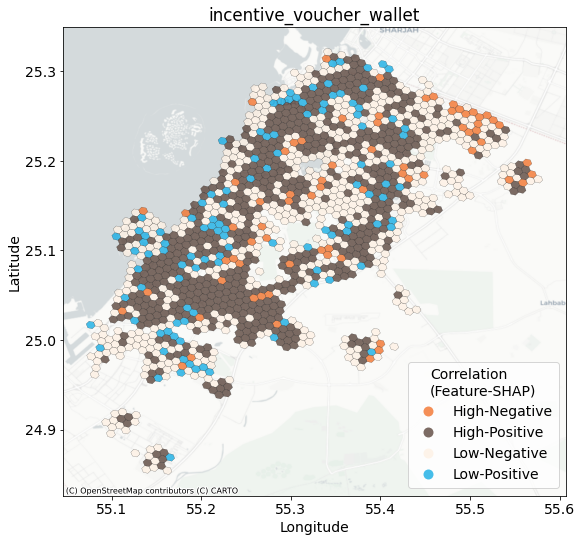

CPU times: user 2.16 s, sys: 301 ms, total: 2.46 s
Wall time: 1.97 s


In [141]:
%%time
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.colors as mcolors

plt.rcParams.update({'font.size': 14})
fig, ax = plt.subplots(1, figsize=(9, 9))
print(selected_feature)
# High-Negative, High-Positive, Low-Negative, Low-Positive
colorlist = ['#f3742e','#5c473e', '#fef1e4','#18aee5']
cmap = mcolors.ListedColormap(colorlist)

hexagon_agg_ordernumber.plot(
    column='Quadrant',         # Categorical column
    cmap=cmap,               # Colormap for categories
    alpha=0.8,
    legend=True,               # Show legend for categories
    categorical=True,          # Specify that the column is categorical
#     markersize= gdf_onefeature[selected_feature]/5,
    edgecolor = 'black',
    linewidth=0.2,
    ax=ax
)

leg = ax.get_legend()
leg.set_bbox_to_anchor((1,0.3))
leg.set_title('Correlation\n(Feature-SHAP)')
cx.add_basemap(ax, crs=gdf_onefeature.crs, source=cx.providers.CartoDB.Positron)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title(selected_feature)
plt.savefig('./output/hex_spatial_SHAP_'+selected_feature+'.png', dpi=300, bbox_inches='tight')
plt.show()

# Spatial analysis of SHAP option 2 - 4 quadrants

In [5]:
# select a sample to speed up
df_shap_merged_test = df_shap_merged.head(10000)
df_shap_merged_test = df_shap_merged_test[['order_id','customer_lon','customer_lat','estimated_rent','shap_estimated_rent']]

#Converting Pandas DataFrame to GeoDataFrame
geometry = [Point(xy) for xy in zip(df_shap_merged_test.customer_lon, df_shap_merged_test.customer_lat)]
gdf = GeoDataFrame(df_shap_merged_test, crs="EPSG:4326", geometry=geometry)

In [6]:
gdf.loc[(gdf['estimated_rent']>=gdf['estimated_rent'].mean()) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'High-Positive'
gdf.loc[(gdf['estimated_rent']>=gdf['estimated_rent'].mean()) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'High-Negative'
gdf.loc[(gdf['estimated_rent']<gdf['estimated_rent'].mean()) & (gdf['shap_estimated_rent']>0),'Quadrant'] = 'Low-Positive'
gdf.loc[(gdf['estimated_rent']<gdf['estimated_rent'].mean()) & (gdf['shap_estimated_rent']<=0),'Quadrant'] = 'Low-Negative'
gdf.Quadrant.value_counts()

Low-Negative     4410
High-Positive    2883
Low-Positive     1667
High-Negative    1040
Name: Quadrant, dtype: int64

In [8]:
%%time

# Low & Negative: Something muted, like light gray (to indicate low values and negative impact).
# Low & Positive: Light blue (to show low values but positive impact).
# High & Negative: Orange (to indicate high values with negative impact).
# High & Positive: Green (to highlight the best combination—high values and positive impact).
# cmap = mcolors.ListedColormap(['Orange', 'Green', 'lightgray', 'lightblue'])

# High-Negative, High-Positive, Low-Negative, Low-Positive
color2 = ['#f3742e','#5c473e', '#fef2e5','#18aee5']

gdf.head(1000).explore(
    column='Quadrant',  # make choropleth based on "BoroName" column
    popup=True,  # show all values in popup (on click)
    tiles="CartoDB positron",  # use "CartoDB positron" tiles #OpenStreetMap
    cmap=color2,
    style_kwds=dict(color="gray",weight='0.1',fillOpacity=0.6, style_function=lambda x: {"radius":x["properties"]["estimated_rent"]/50})
)

CPU times: user 142 ms, sys: 3.4 ms, total: 145 ms
Wall time: 611 ms
